# FISH - Pipeline - A Python notebook to simulate FISH data

```
Author: Luis U. Aguilera
Contact Info: luis.aguilera@colostate.edu

Copyright (c) 2021 Munsky Group 
Colorado State University 
Licensed under BSD 3-Clause License.
```

### Libraries

In [1]:
# Importing libraries
import sys
import pathlib
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import morphology
from scipy.ndimage import gaussian_filter
from matplotlib.patches import Rectangle

warnings.filterwarnings("ignore")

### Path to source directories

In [2]:
# Defining directories
current_dir = pathlib.Path().absolute()
fa_dir = current_dir.parents[0].joinpath('src')
database_simulation_path = current_dir.parents[0].joinpath('database_simulation')

# Importing fish_analyses module
sys.path.append(str(fa_dir))
import fish_analyses as fa

# Path to credentials
desktop_path = pathlib.Path.home()/'Desktop'
path_to_config_file = desktop_path.joinpath('config.yml')

In [3]:
# Path to data
cell_library_folder_path = database_simulation_path.joinpath('cell_library')
background_library_path = = database_simulation_path.joinpath('cell_library','background_pixels_library.npy')
dataframe_library_path = = database_simulation_path.joinpath('cell_library','dataframe_library.csv')


In [4]:
# Read dataframe
dataframe = pd.read_csv(dataframe_file_path)
# Read each image and save as a list
list_images, path_files, list_files_names, number_images = fa.ReadImages(directory= data_folder_path).read()
# read mask images
list_images_masks, path_files_masks, list_files_names_masks, number_images_masks = fa.ReadImages(directory= path_to_masks_dir).read()
# Reordering indices
masks_nuclei_indexes = [index for index, element in enumerate(list_files_names_masks) if 'masks_nuclei_R' in element]

In [8]:
selected_image = 1
list_library_cells = extracting_individual_cells(original_image=list_images[selected_image],
                                                    masks_image=list_images_masks[masks_nuclei_indexes[selected_image]],
                                                    remove_extreme_values=False)

___

# Function to simulate cell positions

In [13]:
def generate_simulated_positions (image_size_Z_Y_X,number_of_cells_in_simulation,list_library_cells,generate_cells_close_to_each_other=True):
    initial_dictionary_for_df = {
        'cell_number': [],
        'z_position': [],
        'y_position': [],
        'x_position': [],
        'z_size': [],
        'y_size': [],
        'x_size': [],
        'library_id': [],
    }
    # this statement generate a large number of cells if generate_cells_close_to_each_other is true.
    if generate_cells_close_to_each_other == True:
        large_number_initial_simulation = number_of_cells_in_simulation*3
    else:
        large_number_initial_simulation = number_of_cells_in_simulation
    # Create the DataFrame
    number_cells_in_library = len(list_library_cells)
    max_cell_size = np.max( [np.max(cell.shape[1:3]) for _, cell in enumerate(list_library_cells)] )
    
    simulation_dataframe = pd.DataFrame(initial_dictionary_for_df)
    #max_cell_size 
    MAX_NUM_ITERATIONS = 20000
    printed_cells=0
    min_position_image_edge = max_cell_size
    max_y_position = image_size_Z_Y_X[1]-min_position_image_edge
    max_x_position = image_size_Z_Y_X[2]-min_position_image_edge
    counter=0
    # random indexes for selecting a cell from library
    number_cells_in_library = len(list_library_cells)
    rnd_index_cells = np.random.randint(0, number_cells_in_library,size=MAX_NUM_ITERATIONS).astype(int)
    # This creates a random positions with a len MAX_NUM_ITERATIONS
    y_positions = np.random.randint(min_position_image_edge, max_y_position-max_cell_size, size=MAX_NUM_ITERATIONS).astype(int)
    x_positions = np.random.randint(min_position_image_edge, max_x_position-max_cell_size, size=MAX_NUM_ITERATIONS).astype(int)
    z_positions = np.zeros(MAX_NUM_ITERATIONS,dtype=int)
    cell_size_Z_Y_X = np.zeros((number_cells_in_library,3))
    for i in range (number_cells_in_library):
        cell_size_Z_Y_X[i,:] = list_library_cells[i][:,:,:,0].shape
    # Main while loop that iterates until number_of_cell_in_image is reached or counter>MAX_NUM_ITERATIONS
    list_cells_position = []
    while (counter< MAX_NUM_ITERATIONS-1) and (printed_cells<=large_number_initial_simulation-1):
        add_cell = False
        tested_positions=[]
        if printed_cells >0:
            # Test cell positions
            cell_Z_Y_X_positions = [z_positions[counter], y_positions[counter], x_positions[counter]]
            tested_positions = list_cells_position.copy()
            tested_positions.append(cell_Z_Y_X_positions) 
            array_tested_positions = np.asarray( tested_positions)
            # Calculating a distance matrix. 
            distance_matrix = np.zeros( (array_tested_positions.shape[0], array_tested_positions.shape[0])) 
            for i in range(len(array_tested_positions)):
                for j in range(len(array_tested_positions)):
                    if j<i:
                        distance_matrix[i,j] = np.linalg.norm( ( array_tested_positions[i,:]-array_tested_positions[j,:] )  )
            # Masking the distance matrix. Ones indicate the distance is less or equal than threshold_distance
            mask_distance_matrix = (distance_matrix <= max_cell_size) 
            # Negation (NOT) of the distance_matrix .
            negation_subsection_mask_distance_matrix = ~mask_distance_matrix
            lower_diagonal_mask_distance_matrix = np.tril(negation_subsection_mask_distance_matrix, k=-1)
            add_cell = np.all(lower_diagonal_mask_distance_matrix[-1,:-1])
            del array_tested_positions
        else:
            cell_Z_Y_X_positions = [z_positions[counter], y_positions[counter], x_positions[counter]]
            add_cell = True
        if add_cell == True: 
            library_cell_index = rnd_index_cells[counter]
            list_cells_position.append(cell_Z_Y_X_positions)
            cell_data = pd.Series([ printed_cells,z_positions[counter], y_positions[counter], x_positions[counter],cell_size_Z_Y_X[library_cell_index,0], cell_size_Z_Y_X[library_cell_index,1], cell_size_Z_Y_X[library_cell_index,2]  ,library_cell_index ], index=simulation_dataframe.columns)
            simulation_dataframe = simulation_dataframe.append(cell_data, ignore_index=True)
            printed_cells+=1
        counter+=1
    new_dtypes = {'cell_number':int, 'z_position':int, 'y_position':int,'x_position':int,'z_size':int,'y_size':int,'x_size':int,'library_id':int}
    simulation_dataframe = simulation_dataframe.astype(new_dtypes)
    
    if generate_cells_close_to_each_other == True:
        # Calculating the distance matrix of selected cells
        tested_positions = simulation_dataframe[['y_position', 'x_position']]
        tested_positions.values.shape
        array_tested_positions = np.asarray( tested_positions)
        # Calculating a distance matrix. 
        distance_matrix = np.zeros( (array_tested_positions.shape[0], array_tested_positions.shape[0])) 
        for i in range(len(array_tested_positions)):
            for j in range(len(array_tested_positions)):
                distance_matrix[i,j] = np.linalg.norm( ( array_tested_positions[i,:]-array_tested_positions[j,:] )  )
        # Calculating the distance of the closest N cells around a given cell
        sum_rows = []
        number_neighbor_cell = 8
        for i in range(distance_matrix.shape[0]):
            row_values = distance_matrix[i]
            n_min_values_indices = np.argsort(row_values)[:number_neighbor_cell]
            sum_rows.append( np.sum(row_values[n_min_values_indices]))
        sum_rows = np.asarray(sum_rows)
        # Selecting only number_of_cells_in_simulation 
        selected_indices = np.argsort(sum_rows)[:number_of_cells_in_simulation]
        simulation_dataframe_new = simulation_dataframe.iloc[selected_indices].copy()
        simulation_dataframe_new = simulation_dataframe_new.reset_index(drop=True)
        simulation_dataframe_new['cell_number'] =simulation_dataframe_new.index
        simulation_dataframe_new
        simulation_dataframe = simulation_dataframe_new
        simulation_dataframe
    
    return simulation_dataframe

In [14]:
complete_size = 5000

In [15]:
full_image_size_Z_Y_X = [27,complete_size,complete_size]
number_of_cells_in_simulation = 150
simulation_dataframe = generate_simulated_positions (full_image_size_Z_Y_X,number_of_cells_in_simulation,list_library_cells)
simulation_dataframe.tail()                                            

,cell_number,z_position,y_position,x_position,z_size,y_size,x_size,library_id
145,145,0,3699,571,27,93,100,9
146,146,0,1334,4654,27,65,93,2
147,147,0,1764,2494,27,91,64,1
148,148,0,3080,2165,27,105,78,8
149,149,0,2915,1388,27,105,70,4


# Generate simulation on demand

In [16]:
def make_simulated_image_expanded(z_range,y_range,x_range,full_image_size_Z_Y_X,simulation_dataframe,list_library_cells,background_elements_in_image=None):
    full_image_z_range = (0,full_image_size_Z_Y_X[0])
    
    # Detecting cells inside the selected region
    z_pixels = z_range[1]-z_range[0]
    def min_edge_value_full_image (tested_value,edge_values,original_edge):
        if tested_value<edge_values:
            new_range = 0
        else:
            new_range = tested_value
        moved_pixels =abs(original_edge-new_range)
        return new_range,moved_pixels
    def max_edge_value_full_image (tested_value,edge_values,original_edge):
        if tested_value>edge_values:
            new_range = edge_values
        else:
            new_range = tested_value
        moved_pixels =abs(new_range-original_edge)
        return new_range,moved_pixels
    # extending the image range to consider cell on the image border
    additional_range = 200
    extended_y_min_range,moved_px_y_min = min_edge_value_full_image(y_range[0]-additional_range,0,y_range[0])
    extended_x_min_range,moved_px_x_min = min_edge_value_full_image(x_range[0]-additional_range,0,x_range[0])
    extended_y_max_range,moved_px_y_max = max_edge_value_full_image(y_range[1]+additional_range,full_image_size_Z_Y_X[1],y_range[1])
    extended_x_max_range,moved_px_x_max = max_edge_value_full_image(x_range[1]+additional_range,full_image_size_Z_Y_X[2],x_range[1])
    extended_y_pixels = extended_y_max_range - extended_y_min_range
    extended_x_pixels = extended_x_max_range - extended_x_min_range
    number_color_channels = list_library_cells[0].shape[3]
    # Function to calculate ranges
    def return_ranges(selected_row, initial_x_range=None, initial_y_range=None):
        tested_x_size = selected_row.x_size
        tested_y_size = selected_row.y_size
        is_even_x = tested_x_size%2== 0
        is_even_y = tested_y_size%2== 0
        if not (initial_x_range is None):
            tested_x_position = selected_row.x_position - initial_x_range
        else:
            tested_x_position = selected_row.x_position
        if not (initial_y_range is None): 
            tested_y_position = selected_row.y_position - initial_y_range
        else:
            tested_y_position = selected_row.y_position 
        min_y_value = tested_y_position - tested_y_size//2
        max_y_value = tested_y_position + tested_y_size//2 + int(is_even_x)
        min_x_value = tested_x_position - tested_x_size//2
        max_x_value = tested_x_position + tested_x_size//2 + int(is_even_y)
        return min_y_value,max_y_value,min_x_value,max_x_value
    list_is_inside_range =[]
    for _, selected_row in simulation_dataframe.iterrows():
        min_y_value,max_y_value,min_x_value,max_x_value = return_ranges(selected_row,initial_x_range=None,initial_y_range=None)
        is_inside_range = (min_x_value >= extended_x_min_range) & (max_x_value <= extended_x_max_range) & (min_y_value >= extended_y_min_range) & (max_y_value <= extended_y_max_range)
        list_is_inside_range.append(is_inside_range)
    # Test one by one if a cell is located inside the 
    condition = np.array(list_is_inside_range)
    dataframe_cells_in_image = simulation_dataframe[condition]
    dataframe_cells_in_image
    # take the image position and the cell location
    number_cells_in_library = len(list_library_cells)
    volume_simulated_image = np.zeros ((z_pixels,extended_y_pixels,extended_x_pixels,number_color_channels ),dtype=int)
    # Repetitive calculation performed over library of cells. Including cell shapes, cell_indexes, simulated volumes
    list_volume_tested_cell=[]
    for i in range (number_cells_in_library):
        list_volume_tested_cell.append(list_library_cells[i][z_range[0]:z_range[1],:,:,:].astype(int))
    # Lambda function to calculate edges in simulation
    min_edge_simulation = lambda tested_value:  0 if tested_value<0 else tested_value
    # main loop that creates the simulated image
    for _, selected_row in dataframe_cells_in_image.iterrows():
        library_id_selected = selected_row.library_id
        volume_selected_cell = list_volume_tested_cell[library_id_selected]
        min_y_value,max_y_value,min_x_value,max_x_value = return_ranges(selected_row,initial_x_range=extended_x_min_range,initial_y_range= extended_y_min_range)
        # Positions in final simulation
        y_min_in_simulation = min_edge_simulation(min_y_value)
        x_min_in_simulation = min_edge_simulation(min_x_value) 
        # Subsection of the volume to add to the final image
        sub_volume_selected_cell = volume_selected_cell[:,:,:, :].copy()
        sim_y_max = y_min_in_simulation + sub_volume_selected_cell.shape[1]
        sim_x_max = x_min_in_simulation + sub_volume_selected_cell.shape[2]
        # adding the cell to the image
        volume_simulated_image[:,y_min_in_simulation:sim_y_max,x_min_in_simulation:sim_x_max, :] =  sub_volume_selected_cell 
        del sub_volume_selected_cell
    if not background_elements_in_image is None: 
        # adding background noise
        simulated_image = np.zeros_like(volume_simulated_image)
        for i in range (number_color_channels):
            temp_simulated_image = volume_simulated_image[:,:,:,i].copy()
            zero_indices = np.where(temp_simulated_image == 0)
            random_elements = np.random.choice(background_elements_in_image[i,:], size=len(zero_indices[0]))
            # Replace zero elements with random elements
            temp_simulated_image[zero_indices] = random_elements
            simulated_image[:,:,:,i] = temp_simulated_image
    else:
        simulated_image =volume_simulated_image
        
    # Removing cells in dataframe that are outside the field of view 
    
    
    # Calculate the new positions in the field of view
    
    
    # Also return the new DF
    
    
    
    # Reshaping the final image
    simulated_image =simulated_image[:,moved_px_y_min:-moved_px_y_max-1,moved_px_x_min:-moved_px_x_max-1,:].copy()
    return simulated_image

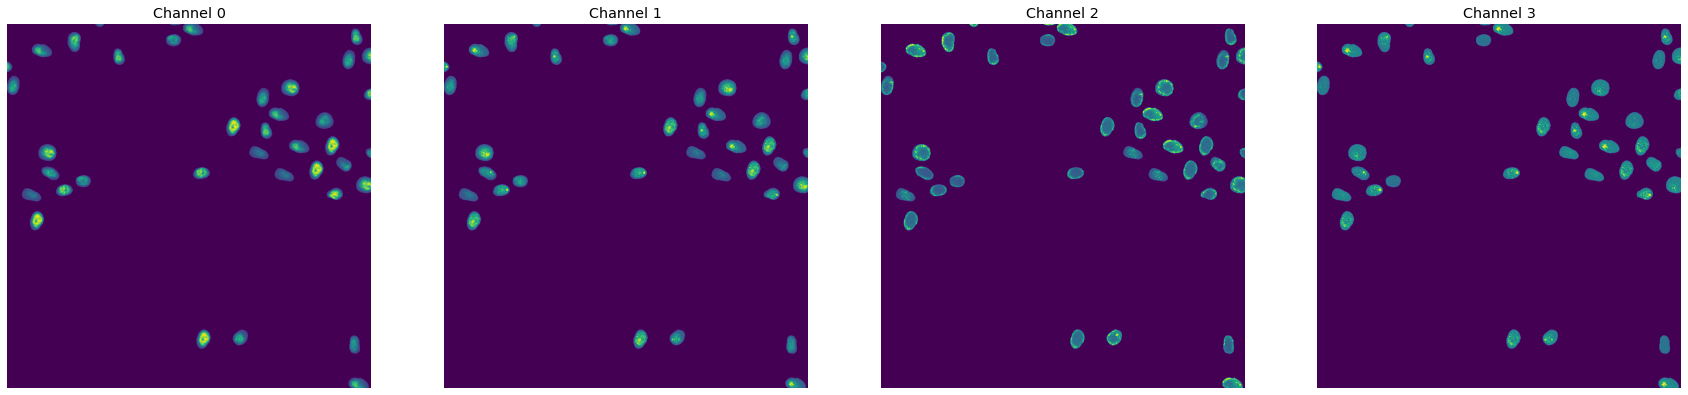

In [17]:
# Region to display
z_range = [15,16] # fix to accept single z-axis
y_range = [2000,4000]
x_range = [2000,4000]
simulated_image = make_simulated_image_expanded(z_range,y_range,x_range,full_image_size_Z_Y_X,simulation_dataframe,list_library_cells)
# Plotting
number_color_channels = simulated_image.shape[3]
fig, ax = plt.subplots(1,number_color_channels, figsize=(30, 7))
# Plotting the heatmap of a section in the image
for i in range (number_color_channels):
    temp_max = np.max(simulated_image[:,:,:,i],axis = 0)
    max_proj = fa.RemoveExtrema(temp_max,min_percentile=0, max_percentile=99.9).remove_outliers()  #np.max(simulated_image[:,:,:,i],axis = 0)
    ax[i].imshow(max_proj);ax[i].set(title='Channel '+ str(i)); ax[i].axis('off');ax[i].grid(False)
plt.show()

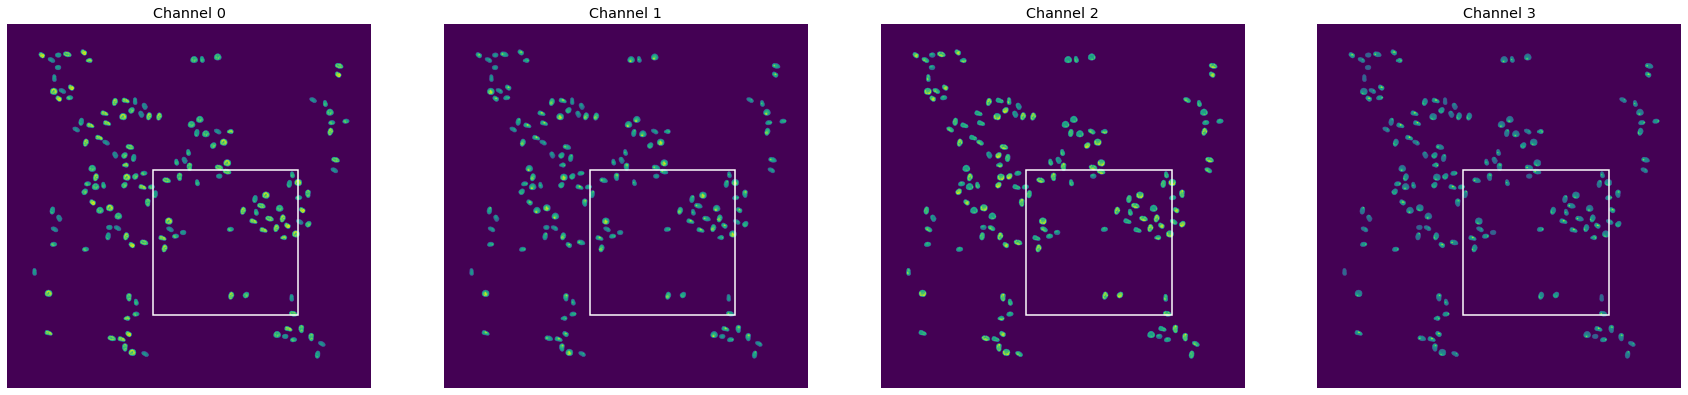

In [18]:
# Region to display
z_range_complete = [0,27]
y_range_complete = [0,complete_size]
x_range_complete = [0,complete_size]
simulated_image = make_simulated_image_expanded(z_range_complete,y_range_complete,x_range_complete,full_image_size_Z_Y_X,simulation_dataframe,list_library_cells)

# Plotting
number_color_channels = simulated_image.shape[3]
fig, ax = plt.subplots(1,number_color_channels, figsize=(30, 7))
# Plotting the heatmap of a section in the image
for i in range (number_color_channels):
    temp_max = np.max(simulated_image[:,:,:,i],axis = 0)
    max_proj = fa.RemoveExtrema(temp_max,min_percentile=0, max_percentile=99.9).remove_outliers()  #np.max(simulated_image[:,:,:,i],axis = 0)
    ax[i].imshow(max_proj);ax[i].set(title='Channel '+ str(i)); ax[i].axis('off');ax[i].grid(False)
    # Plotting rectangle
    xy = (x_range[0], y_range[0])
    width = x_range[1]-x_range[0]
    height = y_range[1] - y_range[0]
    ax[i].add_patch(Rectangle(xy , width,height, fill=False,edgecolor=[1,1,1],lw=1.5))
    ax[i].axis('off');ax[i].grid(False)
    
plt.show()

In [19]:
# TODO LIST

# REMOVE SEGMENTED CELL LOCATED ON THE IMAGE.
# ADD BLURRY TO OUT OF FOCUS FRAMES.
# MAKE SURE THAT THE CODE ONLY RETURNS A SINGLE Z-FRAME.
# CREATE A COMPLETE DATABASE WITH MULTIPLE EXAMPLES. 
# USE ONLY TWO COLOR CHANNELS. THE ONE WITH FISH AND THE ONE WITH THE NUCLEUS.
# QUANTIFY SPOTS ON EACH CELL AND ADD IT TO THE DATAFRAME. 
# WORK ON THE INTERFACE TO HAVE THE FORM NEEDED BY MICHAEL.

